# Modifica la classe di backtesting in modo che abbia una funzione, utilizzabile solo dopo aver trovato i parametri ottimali, che mostri in rosso la heatmap della performance e in blu la heatmap del massimo drawdown.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("seaborn")

In [2]:
import tpqoa
api = tpqoa.tpqoa("oanda.cfg")

# Basic class and constructor

In [3]:
import seaborn
# self vuol dire che eh una variable di una instanza delloggetto
# dopo facciamo due metodi: una prende dati da oanda e calcola logreturn, laltra usa SMAS e SMAL per calcolare la media mobile
# set_params promete la possibilita di cambiare i parametri e risettare tutti i valore nella tabellina in base ai nuovi valore
class SMABacktester():
    def __init__(self, symbol, SMA_s, SMA_l, start, end):
        #questo underscore _symbol, _SMA_s indica che la variabile non viene toccata dallesterno e sarebbe protetta
        self._symbol = symbol
        self._SMA_s=SMA_s
        self._SMA_l=SMA_l
        self._start=start
        self._end=end
        self.results=None #none eh variabile vuota
        self.get_data()
        self.prepare_data()
      
    def get_data(self):
        df=api.get_history(instrument=self._symbol, start=self._start, end=self._end, granularity="D", price="B").c.to_frame()
        df["logret"]=np.log(df.c/df.c.shift(1))
        self._data=df
        
    def prepare_data(self):
        self._data["SMA_s"]=self._data.c.rolling(self._SMA_s).mean()
        self._data["SMA_l"]=self._data.c.rolling(self._SMA_l).mean()
        
    def set_parameters(self, SMA_s=None, SMA_l=None):
        if SMA_s is not None:
            self._SMA_s=SMA_s
            self._data["SMA_s"]=self._data.c.rolling(self._SMA_s).mean()
        if SMA_l is not None:
            self._SMA_l=SMA_l
            self._data["SMA_l"]=self._data.c.rolling(self._SMA_l).mean()

    def test_strategy(self):   
        df2 = self._data.dropna().copy() # copia fisica, non puntatore
        df2["position"]=np.where(df2.SMA_s > df2.SMA_l,+1,-1)
        df2["strategy"]=df2.logret * df2.position.shift(1)
        df2["cumlogret"]=df2.logret.cumsum()
        df2["cumstrategy"]=df2.strategy.cumsum()
        performance = df2.cumstrategy.iloc[-1] #df2.strategy.sum() equivalente
        overperformance = performance - df2.cumlogret.iloc[-1] #quando vado meglio a buy and hold, rispett. logret
        maxdrawdown = (df2.cumstrategy.cummax() - df2.cumstrategy).max()
        self.results=df2 #se voglio far un grafico, mi serve
        return round(performance,6), round(overperformance,6), round(maxdrawdown,6)
    
    def plot_results(self):
        if self.results is None:
            print("Prima eseguire test_strategy()")
        else:
            self.results[["cumlogret", "cumstrategy"]].plot(figsize=(25,15))
            plt.legend(fontsize=18)
            titolo=self._symbol + "  SMA_s= " + str(self._SMA_s) + "  SMA_l= " + str(self._SMA_l)
            plt.title(titolo, fontsize=22)
            
    def optimize_parameters(self, SMA_s_range, SMA_l_range):
        combinazioni = list(product(range(SMA_s_range[0], SMA_s_range[1]), range(SMA_l_range[0],SMA_l_range[1])))
        risultati = []
        risultatiDD = []
        for comb in combinazioni:
            self.set_parameters(comb[0], comb[1])
            risultati.append(self.test_strategy()[0])
            risultatiDD.append(self.test_strategy()[2])
        bestPerformance=np.max(risultati)
        bestCombinazione=combinazioni[np.argmax(risultati)]
        bestDD = risultatiDD[np.argmax(risultati)]
        
        self.set_parameters(SMA_s=bestCombinazione[0], SMA_l=bestCombinazione[1])
        
        #mettiamo i risultati in un dataframe
        AllResults = pd.DataFrame(combinazioni, columns=["SMA_s", "SMA_l"])
        AllResults["performance"] = risultati
        AllResults["MaxDrawdown"] = risultatiDD
        self.resultsOverview= AllResults
        
        
        return bestPerformance, bestCombinazione, bestDD
    
    def heatmapPerf(self):
        if self.resultsOverview is None:
            print("Prima eseguire test_strategy() e optimize_parameters()!")
        else:
            resultsDF = self.resultsOverview.copy()
            resultsDF=resultsDF.drop(["MaxDrawdown"], axis=1)
            resultsTable=resultsDF.pivot(index="SMA_s", columns="SMA_l", values="performance")
            plt.figure(figsize=(25,15))
            seaborn.heatmap(resultsTable, cmap="Reds")
            plt.show()
            
    def heatmapDrawd(self):
        if self.resultsOverview is None:
            print("Prima eseguire test_strategy() e optimize_parameters()!")
        else:
            resultsDF = self.resultsOverview.copy()
            resultsDF=resultsDF.drop(["performance"], axis=1)
            resultsTable=resultsDF.pivot(index="SMA_s", columns="SMA_l", values="MaxDrawdown")
            plt.figure(figsize=(25,15))
            seaborn.heatmap(resultsTable, cmap="Blues")
            plt.show()

In [4]:
testerClass=SMABacktester("EUR_USD", 50, 200, "2008-10-01", "2021-10-01")

In [5]:
# testando la classe dopo aver inserito test strategy
testerClass.test_strategy()

(0.333728, 0.479081, 0.233259)

In [6]:
testerClass.optimize_parameters((30,100), (100,200))

(0.844873, (82, 128), 0.142391)

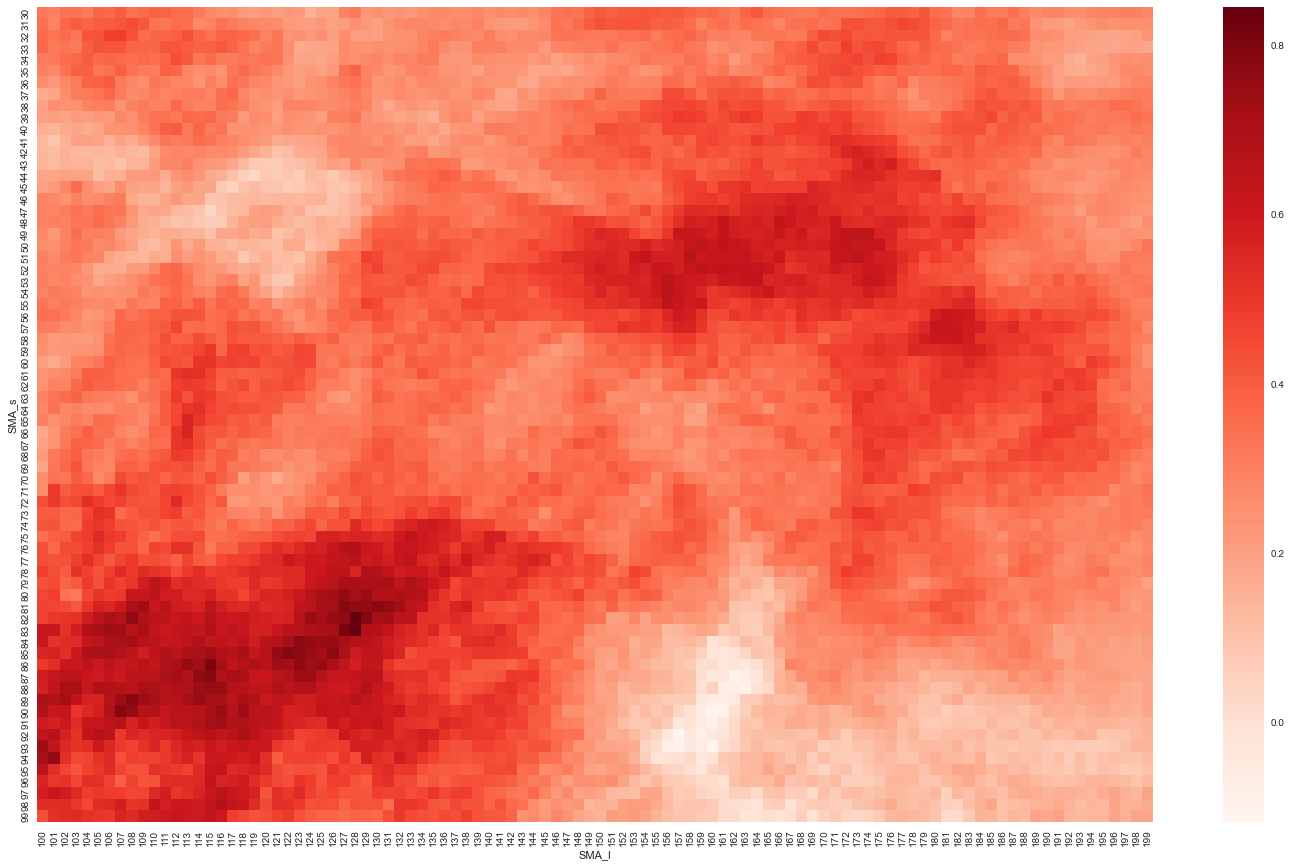

In [7]:
testerClass.heatmapPerf()

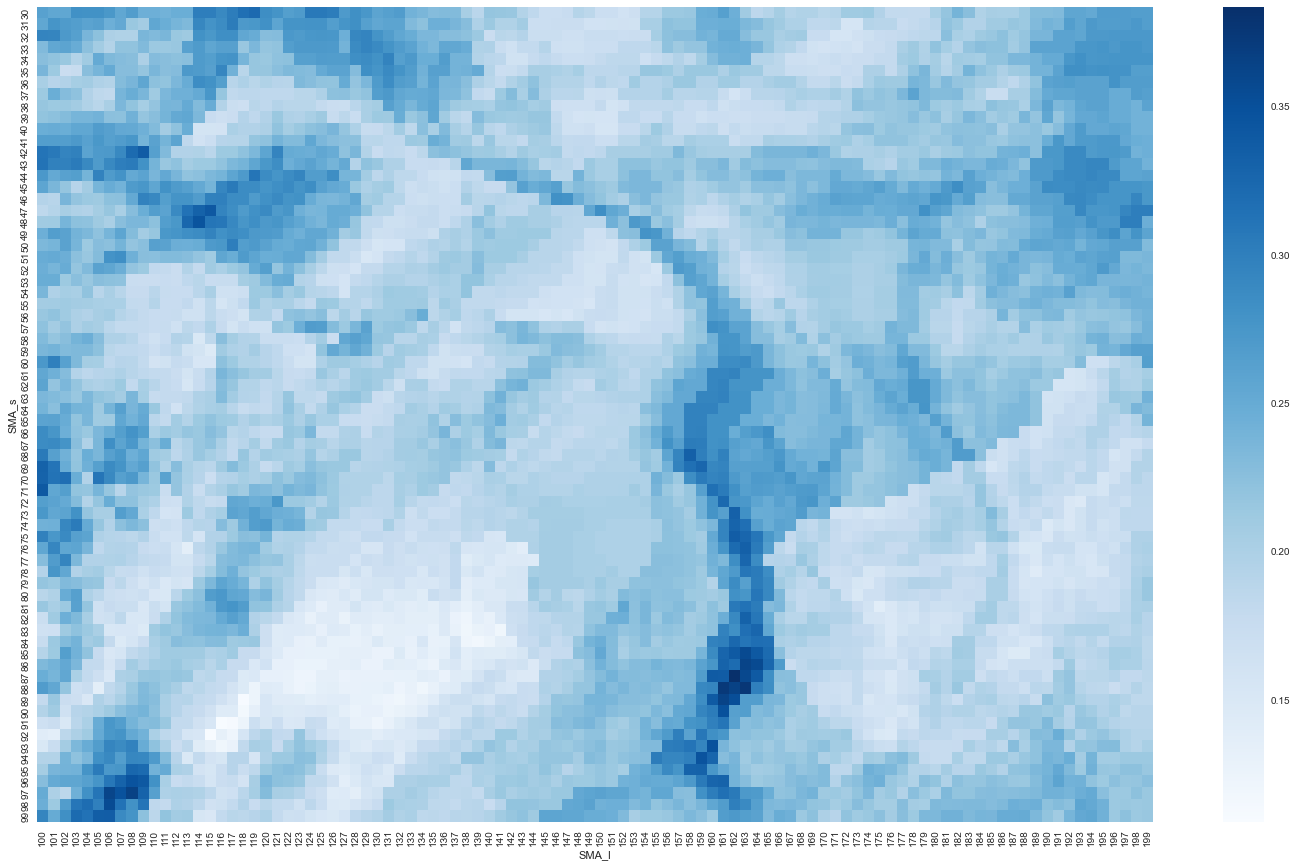

In [8]:
testerClass.heatmapDrawd()